In [ ]:
import onnxruntime as ort
import glob as gb
import pandas as pd
import numpy as np
from utils.plotting_JPDF import plot_JPDF

# Path to trained model
onnx_path = "./../neural_network/saved_models/NN_model_for_uq_analysis.onnx"

# Create session
session = ort.InferenceSession(
    onnx_path,
    providers=["CPUExecutionProvider"]
)

print("Input shape:", session.get_inputs()[0].shape)
print("Output shape:", session.get_outputs()[0].shape)


In [2]:
# Read the data from the FlameMaster files
fname = './../neural_network/data/chemtable_FVV_2D_Enthalpy/*.kg'
files = gb.glob(fname)
nfiles = len(files)


# Read column names from the second line of the first file
with open(files[0], 'r') as f:
    lines = f.readlines()
    column_names = lines[1].strip().split('\t')  # Read second line (index 1) and split by whitespace

# Create empty lists to store the data
data_flameMaster = []

# Load and concatenate the data into DataFrames
for f in files:

    df_flameMaster_temp = pd.DataFrame(np.loadtxt(f, skiprows=2, dtype=np.float64),columns=column_names)
    data_flameMaster.append(df_flameMaster_temp)

# Concatenate all data into final DataFrames
df_flameMaster_all = pd.concat(data_flameMaster, ignore_index=True)

#Computing diffusivity 
df_flameMaster_all['Diff [kg/ms]'] = df_flameMaster_all['lambda [W/mK]'] / df_flameMaster_all['cp [J/kgK]']

# Select the relevant columns for input and output
input_data = ['ProgVar', 'TotalEnthalpy [J/kg]']
referenceEnthalpy = 276240

# Shift the enthalpy values to be relative to the reference enthalpy
df_flameMaster_all['TotalEnthalpy [J/kg]'] = df_flameMaster_all['TotalEnthalpy [J/kg]'] - referenceEnthalpy

# Select the relevant columns for input and output
output_data = ['ProdRateProgVar [kg/m^3s]', 'temperature [K]', 'Y-CO', 'density', 'mu [kg/ms]', 'cp [J/kgK]', 'Diff [kg/ms]']

# Create DataFrames for input and output data
X_all = df_flameMaster_all[input_data].to_numpy()
Z_all = df_flameMaster_all[output_data].to_numpy()

# Load mask from trained model
mask = np.load("./../neural_network/train_test_mask.npy")

X_train = X_all[mask].astype(np.float32)
Z_train = Z_all[mask].astype(np.float32)
X_test  = X_all[~mask].astype(np.float32)
Z_test  = Z_all[~mask].astype(np.float32)


In [3]:
sigma_rel = 0.05    # 5% relative uncertainty

# Bounds for clipping (same as MC)
c_min, c_max = float(X_all[:,0].min()), float(X_all[:,0].max())
h_min, h_max = float(X_all[:,1].min()), float(X_all[:,1].max())

def noisy_inputs_from_xi(x0, xi, sigma_rel, c_min, c_max, h_min, h_max):
    """
    x0: (2,) base point [c0,h0]
    xi: (N,2) standard normal noise samples
    """
    x0 = np.asarray(x0, dtype=np.float64)
    X_noisy = x0[None, :] + sigma_rel * x0[None, :] * xi
    X_noisy[:,0] = np.clip(X_noisy[:,0], c_min, c_max)
    X_noisy[:,1] = np.clip(X_noisy[:,1], h_min, h_max)
    return X_noisy


In [4]:
x0 = X_test[0].astype(np.float64)
xi = np.array([[0.0, 0.0],
               [1.0, -1.0],
               [-0.5, 0.2]])
print(noisy_inputs_from_xi(x0, xi, sigma_rel, c_min, c_max, h_min, h_max))


[[6.50266969e-08 5.42680000e+04]
 [6.82780318e-08 5.15546000e+04]
 [6.34010295e-08 5.48106800e+04]]


In [5]:
import numpy as np
import math
import time

# Choose polynomial order (start small)
order = 12  # try 3 or 4 first

# Standardize inputs using training statistics
x_mean = X_train.mean(axis=0)
x_std  = X_train.std(axis=0) + 1e-12

def standardize(X):
    return (X - x_mean) / x_std

# Pick a subset of training data for PCE fit
rng = np.random.default_rng(0)
k=20
P = (order + 1) * (order + 2) // 2
N_fit = k * P  

idx_fit = rng.choice(len(X_train), size=N_fit, replace=False)

X_fit = X_train[idx_fit].astype(np.float64)
Z_fit = Z_train[idx_fit].astype(np.float64)

X_fit_s = standardize(X_fit)
X_test_s = standardize(X_test.astype(np.float64))

print("X_fit_s shape:", X_fit_s.shape)
print("Z_fit shape:", Z_fit.shape)


X_fit_s shape: (1820, 2)
Z_fit shape: (1820, 7)


In [6]:
def hermite_polynomial(n, x):
    if n == 0:
        return np.ones_like(x)
    elif n == 1:
        return x
    return x * hermite_polynomial(n-1, x) - (n-1) * hermite_polynomial(n-2, x)

def orthonormal_hermite(n, x):
    return hermite_polynomial(n, x) / np.sqrt(math.factorial(n))

def total_order_basis_2d(p):
    # list of (i,j) with i+j <= p
    return [(i, j) for i in range(p+1) for j in range(p+1) if i + j <= p]

def design_matrix_2d_hermite(Xs, basis):
    """
    Xs: standardized inputs (N,2)
    returns A: (N, P) where P = len(basis)
    """
    z1 = Xs[:, 0]
    z2 = Xs[:, 1]
    N = Xs.shape[0]
    P = len(basis)
    A = np.zeros((N, P), dtype=np.float64)

    # precompute H_n(z1), H_n(z2) up to max degree
    max_deg = max(max(i, j) for i, j in basis)
    H1 = np.stack([orthonormal_hermite(n, z1) for n in range(max_deg+1)], axis=1)  # (N, max_deg+1)
    H2 = np.stack([orthonormal_hermite(n, z2) for n in range(max_deg+1)], axis=1)

    for k, (i, j) in enumerate(basis):
        A[:, k] = H1[:, i] * H2[:, j]
    return A

basis = total_order_basis_2d(order)
print("order:", order, "| P terms:", len(basis))

A_fit = design_matrix_2d_hermite(X_fit_s, basis)
A_test = design_matrix_2d_hermite(X_test_s, basis)

print("A_fit shape:", A_fit.shape)
print("A_test shape:", A_test.shape)


order: 12 | P terms: 91
A_fit shape: (1820, 91)
A_test shape: (16386, 91)


In [7]:
def fit_pce(A, Y, ridge=0.0):
    """
    Fit coefficients for multi-output regression:
      A: (N,P)
      Y: (N,7)
    Returns W: (P,7)
    """
    if ridge <= 0.0:
        # least squares
        W, *_ = np.linalg.lstsq(A, Y, rcond=None)
        return W
    else:
        # ridge: (A^T A + λI)W = A^T Y
        P = A.shape[1]
        ATA = A.T @ A
        ATY = A.T @ Y
        W = np.linalg.solve(ATA + ridge*np.eye(P), ATY)
        return W

t0 = time.time()
W = fit_pce(A_fit, Z_fit, ridge=1e-10)  # tiny ridge for stability
t1 = time.time()

Y_pred = A_test @ W  # (N_test,7)

print("Fit time (s):", t1 - t0)
print("Y_pred shape:", Y_pred.shape)


Fit time (s): 0.0015571117401123047
Y_pred shape: (16386, 7)


ProdRateProgVar [kg/m^3s]      rRMSE = 9.8537 %
temperature [K]                rRMSE = 0.1528 %
Y-CO                           rRMSE = 3.2243 %
density                        rRMSE = 0.0683 %
mu [kg/ms]                     rRMSE = 0.1241 %
cp [J/kgK]                     rRMSE = 0.1892 %
Diff [kg/ms]                   rRMSE = 0.1002 %
R2: 0.9990, NMSE: 0.000817820107300154


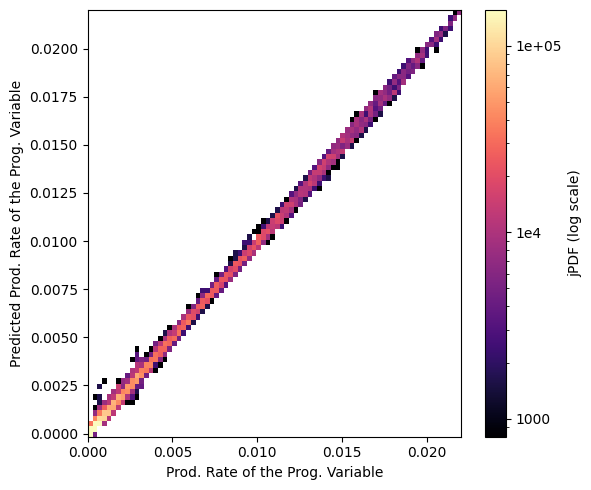

In [8]:
# NMSE per output: mean((e^2)) / mean((y_true^2))
Y_true = Z_test.astype(np.float64)

eps = 1e-12
rRMSE = np.sqrt(np.mean((Y_pred - Y_true) ** 2, axis=0)) / (Y_true.std(axis=0) + eps)

for name, e in zip(output_data, rRMSE):
    print(f"{name:30s} rRMSE = {e* 100:.4f} %")


plot_JPDF(
    df_true=Y_true[:, 2],
    df_pred=Y_pred[:, 2],
    bins=80,
    x_label="Prod. Rate of the Prog. Variable",
    y_label="Predicted Prod. Rate of the Prog. Variable",
)